# Lavazza Logistics Network - Student Version

The logistics department at Lavazza is considering a redesign of their distribution network. Specifically, they are considering opening a second warehouse to reduce transportation costs incurred from delivering products from Lavazza to individual customers.

The current network is shown below (Figure 4 from the case):
<div>
    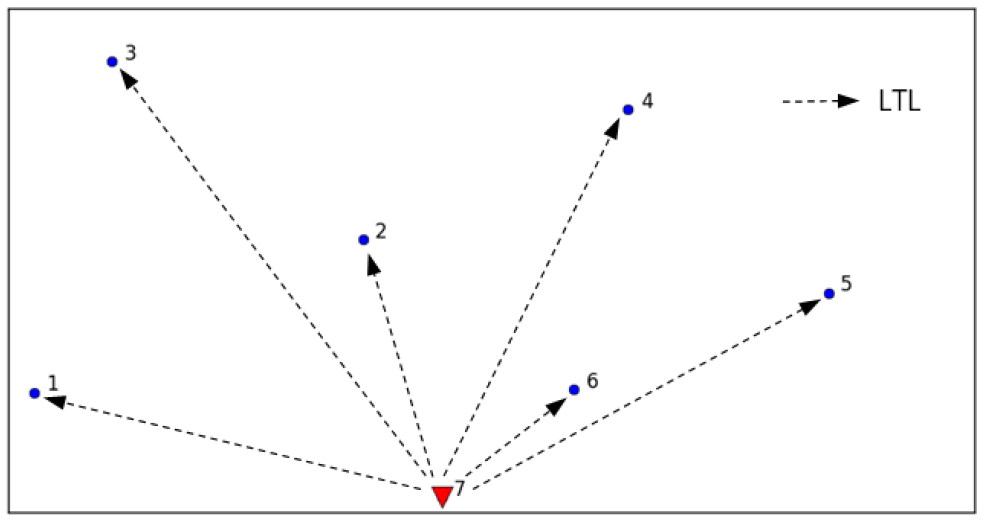
</div>

Customers are located at points 1 through 6. The central warehouse is located at point 7 and deliveries are made using *less-than-truckload (LTL)* shipping. This is a form of distribution where the shipping company (distributor) will carry shipments from several different companies in the same vehicle. The distributor manages the collection and deliveries of these shipments and charges its customers based on the quantity shipped and distance travelled.

The second warehouse that Lavazza wants to open would be located at one of the existing customer locations. Shipments between the central warehouse (point 7) and this second warehouse would be done using *full truckload (FTL)* transport, where the entire shipping container is dedicated to a single customer (compared to LTL, where several customers' products may be shipped in the same container). The volume transported does not matter in FTL shipping, so fees are typically based on distance travelled.

In this notebook, we'll formulate and implement the model described in the case. Let's go!

---
## Current Network Configuration

In [1]:
#Load Gurobi
%pip install gurobipy
import gurobipy as gp
from gurobipy import GRB

#Load useful libraries
import pandas as pd
import numpy as np

### Parameters
Let's denote the possible warehouse locations by $i = 1, 2, 3, 4, 5, 6, 7$. Note that the central warehouse is at location 7.

We will denote the customer locations by $j = 1, 2, 3, 4, 5, 6$. These locations coincide with the possible warehouse locations.

In [6]:
#Set up indexes for the problem
customers = ['1','2','3','4','5','6']
warehouses = ['1','2','3','4','5','6','7']

We are given some data in the problem. The first is expected annual demand (in tonnes) required by each customer. We'll denote this as $d_j$:

In [7]:
#Load demand data
demand = {
    '1': 1500,
    '2': 2300,
    '3': 3000,
    '4': 5500,
    '5': 3000,
    '6': 2300
}

We also have LTL transport costs between customer pairs. We'll denote this as $c_{ik}$ where $i=1, ..., 7$ and $k=1,...,7$.

In [8]:
#Load LTL transport costs
arcs, LTL = gp.multidict({
    ('1','1'): 0.0,
    ('1','2'): 362.0,
    ('1','3'): 594.0,
    ('1','4'): 663.0,
    ('1','5'): 601.0,
    ('1','6'): 391.0,
    ('1','7'): 349.0,
    ('2','1'): 362.0,
    ('2','2'): 0.0,
    ('2','3'): 367.0,
    ('2','4'): 301.0,
    ('2','5'): 350.0,
    ('2','6'): 307.0,
    ('2','7'): 463.0,
    ('3','1'): 594.0,
    ('3','2'): 367.0,
    ('3','3'): 0.0,
    ('3','4'): 383.0,
    ('3','5'): 663.0,
    ('3','6'): 674.0,
    ('3','7'): 814.0,
    ('4','1'): 663.0,
    ('4','2'): 301.0,
    ('4','3'): 383.0,
    ('4','4'): 0.0,
    ('4','5'): 357.0,
    ('4','6'): 500.0,
    ('4','7'): 705.0,
    ('5','1'): 601.0,
    ('5','2'): 350.0,
    ('5','3'): 663.0,
    ('5','4'): 357.0,
    ('5','5'): 0.0,
    ('5','6'): 251.0,
    ('5','7'): 460.0,
    ('6','1'): 391.0,
    ('6','2'): 307.0,
    ('6','3'): 674.0,
    ('6','4'): 500.0,
    ('6','5'): 251.0,
    ('6','6'): 0.0,
    ('6','7'): 215.0,
    ('7','1'): 349.0,
    ('7','2'): 463.0,
    ('7','3'): 814.0,
    ('7','4'): 705.0,
    ('7','5'): 460.0,
    ('7','6'): 215.0,
    ('7','7'): 0.0
})

#alternatively, if you had the data in Excel, you could load an xls or csv file as a dataframe, and take advantage of gurobipy-pandas

Finally, we have the average warehouse handling units costs, $m_i$.

In [9]:
#Load warehouse handling cost data
handling = {
    '1': 20,
    '2': 15,
    '3': 15,
    '4': 20,
    '5': 22,
    '6': 20,
    '7': 18
}

Lavazza wants to develop a lower-cost logistics network than its current configuration. The total cost of the logistics network (based on the data we are given) would be made up of:
1. LTL shipping costs between the warehouses and customer locations
2. FTL shipping costs between the two warehouses
3. warehouse handling costs

### Decision Variables
The LTL shipping costs depend on the volume shipped using LTL transportation. Let $x_{ij}$ be the volume (tonnes) of product shipped between the warehouse $i$ and customer location $j$, where $i, j =1,2,3,4,5,6,7$.

The FTL shipping costs depend on the volume shipped using FTL transportation. (Recall that FTL shipping costs are 40% less than LTL costs.) Similarly, the warehouse handling costs will depend on the volume shipped through the warehouses. Let $z_i$ be the volume (tonnes) of product shipped between the central warehouse (location 7) and the other warehouse in operation $i=1,2,3,4,5,6,7$.

We have enough to get us started with our model formulation (but we will add more as we go).

In [31]:
#Initialize the model
m = gp.Model("Lavazza")

#add decision variables
Xvar = m.addVars(arcs, name="LTL") #volume to ship from i to j using LTL transport
Zvar = m.addVars(warehouses, name = "FTL") #volume to ship from central warehouse to new warehouse using FTL transport

### Objective Function
We will minimize the total cost of LTL shipping + FTL shipping + warehouse handling costs:

\begin{equation}
    \min \quad \sum_{i=1}^{7}\sum_{j=1}^{6}c_{ij}x_{ij} + 0.6\sum_{i=1}^{6}c_{7i}z_i + \sum_{i=1}^{7}m_i z_i
\end{equation}

In [32]:
#add objective function
LTL_costs = Xvar.prod(LTL) #LTL shipping costs
FTL_costs = 0.6*gp.quicksum(LTL['7',i]*Zvar[i] for i in warehouses) #FTL shipping costs
hdlg_costs = gp.quicksum(handling[i]*Zvar[i] for i in warehouses)

m.setObjective(LTL_costs + FTL_costs + hdlg_costs, GRB.MINIMIZE)

### Constraints
Customer demand at each location must be met. This means that the total volume customer $j$ receives from all warehouses $i$ must equal the demand required.
\begin{equation}
    \sum_{i=1}^7x_{ij} = d_j \quad \forall j = 1, 2, 3, 4, 5, 6
\end{equation}

In [33]:
#add demand constraint to model
demand_cstr = m.addConstrs((Xvar.sum('*',j) == demand[j] for j in customers), name='demand_cstr')

Next, the total amount shipped from a warehouse must equal the amount it receives from the central warehouse.

\begin{equation}
    \sum_{j=1}^6 x_{ij} = z_i \quad \forall i=1,2,3,4,5,6,7
\end{equation}

In [34]:
#add supply constraint to model
supply_cstr = m.addConstrs((Xvar.sum(i,'*') == Zvar[i] for i in warehouses), name='supply_cstr')

The constraints above are great.... but we haven't included a way to choose where a new warehouse will be located. Let's introduce a new variable:

***Adding a binary variable***

Let $y_i$ = 1 if a warehouse is opened at location $i = 1, ..., 7$, 0 otherwise.

In [35]:
#add binary variables to model
Yvar = m.addVars(warehouses, vtype=GRB.BINARY, name = "y")

First, let's ensure that the central warehouse at location 7 is open:
\begin{equation}
    y_7 = 1
\end{equation}

In [36]:
#add constraint to ensure central warehouse is open
central_warehouse = m.addConstr(Yvar['7'] == 1, name = 'central_warehouse')

Before we look into the second warehouse to open, let's establish a baseline and see what the cost of the current network configuration is with just one warehouse open. In conjunction with the constraint above, let's ensure only one warehouse is open in total:
\begin{equation}
    \sum_{i=1}^7 y_i = 1
\end{equation}

In [37]:
#add constraint to require just one warehouse to be open
one_warehouse = m.addConstr(gp.quicksum(Yvar[i] for i in warehouses) == 1, name = "single_warehouse")

Now let's link these binary variables, $y_i$, to our flow variables, $x_{ij}$. We cannot ship anything from $i$ to $j$ unless the warehouse at $i$ is actually open. 

For example, if there's no warehouse at location 1 (i.e., $y_1 = 0$) then the total amount shipped out of location 1 should also equal zero (i.e., $\sum_j x_{1,j} = 0$).

However, if there is a warehouse open at location 1 ($y_1 = 1$), then the total amount that could be shipped out of location 1 is not limited. 

We can represent both of these conditions in the following constraint:

\begin{equation}
    \sum_{j=1}^6x_{ij} \le My_i \quad \forall i = 1, ..., 7
\end{equation}

What is $M$? It represent some *big* number. Let's see how this works:

If location 1 is not used, then $y_1 = 0$ and the constraint above will turn into 
\begin{equation} x_{11} + x_{12} + x_{13} + x_{14} + x_{15} + x_{16} \le 0 \end{equation}

If location 1 is used, then $y_1 = 1$ and the constraint above will be
\begin{equation} x_{11} + x_{12} + x_{13} + x_{14} + x_{15} + x_{16} \le M \end{equation}

Since you will have to input a value $M$ when you implement the code in Gurobi, try to choose something meaningful. The value of $M$ should be big enough that is doesn't restrict the flow from warehouse $i$ to the other customers, but it doesn't have to be infinite... Logically, you won't ship more than the *total demand* of the entire network through a single location. So it makes sense, for this problem, for $M = \sum_j d_j = 17600$.

In [38]:
#set value for big M
M = sum(demand.values()) #assign a value to big M

#add linking constraint
linking_cstr = m.addConstrs((Xvar.sum(i,'*') <= M*Yvar[i] for i in warehouses), name = "links")

In [19]:
#write the model to an LP file to inspect
m.write('lavazza_current.lp')

Let's go ahead and solve!

In [20]:
m.optimize()

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: Intel(R) Core(TM) i5-8300H CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 22 rows, 63 columns and 162 nonzeros
Model fingerprint: 0xb83a533c
Variable types: 56 continuous, 7 integer (7 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+04]
  Objective range  [2e+01, 8e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+03]
Presolve removed 22 rows and 63 columns
Presolve time: 0.01s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 1: 1.00992e+07 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.009920000000e+07, best bound 1.009920000000e+07, gap 0.0000%


---
Now to get the objective value:

In [21]:
if m.status == GRB.OPTIMAL:
    #display the objective function value
    currentNetworkCost = m.Objval
    print('Total Cost = %.2f' %currentNetworkCost)

Total Cost = 10099200.00


---
## Network Cost with Two Warehouses
Is having two warehouses cheaper than the original network, where all shipments are by LTL from the central warehouse? Let's modify the original model by first removing the constraint that forces us to have just one open warehouse.

In [39]:
#remove constraint that requires one warehouse to be open
m.remove(one_warehouse)

We'll then add a new constraint that says exactly two warehouses should be open.
\begin{equation}
    \sum_{i=1}^7 y_i = 2
\end{equation}

In [40]:
#add constraint to open exactly two warehouses
two_warehouses = m.addConstr(gp.quicksum(Yvar[i] for i in warehouses) == 2, name = "total_warehouses")

Now, solve this model and interpret the results:

In [24]:
m.write('lavazza_two.lp')
m.optimize()

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: Intel(R) Core(TM) i5-8300H CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 22 rows, 63 columns and 162 nonzeros
Model fingerprint: 0xa4ff94b4
Variable types: 56 continuous, 7 integer (7 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+04]
  Objective range  [2e+01, 8e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+03]

MIP start from previous solve did not produce a new incumbent solution
MIP start from previous solve violates constraint total_warehouses by 1.000000000

Presolve removed 12 rows and 44 columns
Presolve time: 0.00s
Presolved: 10 rows, 19 columns, 45 nonzeros
Variable types: 14 continuous, 5 integer (5 binary)
Found heuristic solution: objective 9180500.0000

Root relaxation: objective 7.889826e+06, 5 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node

In [25]:
if m.status == GRB.OPTIMAL:
    #display the objective function value
    newNetworkCost = m.Objval
    print('Total Cost = %.2f' %newNetworkCost)
    print('Cost Savings = %.2f' %(currentNetworkCost - newNetworkCost))
    
    #display open warehouses
    print("\nLavazza should open:")
    open_warehouses = m.getAttr('x', Yvar)
    for i in warehouses:
        if open_warehouses[i] > 0:
            print('Warehouse %s' %i)

    #display quantities shipped by FTL
    print("\nQuantities shipped by FTL from central warehouse:")
    FTL_shipments = m.getAttr('x', Zvar)
    for i in warehouses:
        if FTL_shipments[i] > 0:
            print('Warehouse 7 -> %s: %g' %(i,FTL_shipments[i]))
            
    #display quantities shipped by LTL
    print("\nQuantities shipped by LTL from warehouses to customers:")
    LTL_shipments = m.getAttr('x', Xvar)
    for i, j in arcs:
        if LTL_shipments[i, j] > 0:
            print('%s -> %s: %g' % (i, j, LTL_shipments[i, j]))

Total Cost = 8439140.00
Cost Savings = 1660060.00

Lavazza should open:
Warehouse 2
Warehouse 7

Quantities shipped by FTL from central warehouse:
Warehouse 7 -> 2: 10800
Warehouse 7 -> 7: 6800

Quantities shipped by LTL from warehouses to customers:
2 -> 2: 2300
2 -> 3: 3000
2 -> 4: 5500
7 -> 1: 1500
7 -> 5: 3000
7 -> 6: 2300


Why do you think this location was chosen for the second warehouse?

**Solution Interpretation:**

Based on the Figure 4, Warehouse 7 is located closely to main customers 1, 5 and 6.

Therefore, opening a new warehouse (2) will be ideal as traveling distance will be shorter + will bring additional 1,660,060 Euro in savings as new warehouse's location will be further north and it will reduce distance for LTL deliveries to main customers 2, 3, and 4

---
## Impact of demand on network configuration

Does demand impact where the new warehouse will be located? Make the following changes to the data, then re-solve the model and interpret the solution:
- Decrease demand at location 3 by 50%
- Increase demand at location 1 by 50%
- Increase demand at location 5 by 50%

In [30]:
## Updating demand as instructed and re-running all previous lines with codes except those that generated outputs for previous 2 models

demand = {
    '1': 2250,
    '2': 2300,
    '3': 1500,
    '4': 5500,
    '5': 4500,
    '6': 2300
}


In [41]:
# Resolving updated model
m.write('lavazza_two_updated_demand.lp')
m.optimize()

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: Intel(R) Core(TM) i5-8300H CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 22 rows, 63 columns and 162 nonzeros
Model fingerprint: 0x27a6e159
Variable types: 56 continuous, 7 integer (7 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+04]
  Objective range  [2e+01, 8e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+03]
Presolve removed 12 rows and 44 columns
Presolve time: 0.00s
Presolved: 10 rows, 19 columns, 45 nonzeros
Variable types: 14 continuous, 5 integer (5 binary)
Found heuristic solution: objective 8821250.0000

Root relaxation: objective 7.952394e+06, 6 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 7952394.29    0    2 

In [42]:
if m.status == GRB.OPTIMAL:
    #display the objective function value
    newNetworkCost = m.Objval
    print('Total Cost = %.2f' %newNetworkCost)
    print('Cost Savings = %.2f' %(currentNetworkCost - newNetworkCost))
    
    #display open warehouses
    print("\nLavazza should open:")
    open_warehouses = m.getAttr('x', Yvar)
    for i in warehouses:
        if open_warehouses[i] > 0:
            print('Warehouse %s' %i)

    #display quantities shipped by FTL
    print("\nQuantities shipped by FTL from central warehouse:")
    FTL_shipments = m.getAttr('x', Zvar)
    for i in warehouses:
        if FTL_shipments[i] > 0:
            print('Warehouse 7 -> %s: %g' %(i,FTL_shipments[i]))
            
    #display quantities shipped by LTL
    print("\nQuantities shipped by LTL from warehouses to customers:")
    LTL_shipments = m.getAttr('x', Xvar)
    for i, j in arcs:
        if LTL_shipments[i, j] > 0:
            print('%s -> %s: %g' % (i, j, LTL_shipments[i, j]))

Total Cost = 8294450.00
Cost Savings = 1804750.00

Lavazza should open:
Warehouse 4
Warehouse 7

Quantities shipped by FTL from central warehouse:
Warehouse 7 -> 4: 7000
Warehouse 7 -> 7: 11350

Quantities shipped by LTL from warehouses to customers:
4 -> 3: 1500
4 -> 4: 5500
7 -> 1: 2250
7 -> 2: 2300
7 -> 5: 4500
7 -> 6: 2300


**Solution Interpretation:**

Based on the updated demand, the handling costs and demand for customers with associated LTL costs lead to conclusion that opening a warehouse 4 is the optimal solution to satisfy all requirements.

New Warehouse 4 will store and dispatch items to customer 3 and 4, while warehouse 7 will cover all remaining customers.

Cost benefit with warehouse 2 open: 1,660,060 vs. 1,804,750 Euro. Therefore, the model solution is optimal given the updated demand.